In [1]:
%pylab inline
import numpy, scipy, pandas as pd
import itertools
from umap import UMAP
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

numpy.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


In [67]:
experiments = numpy.loadtxt("/data/search_ui/data/ENCODE_Tracks.txt", dtype=str, delimiter="\t")
celltypes = numpy.unique(experiments[:,0])
assays = numpy.unique(experiments[:,1])

experiments = numpy.array([(celltype, assay) for celltype, assay in itertools.product(celltypes, assays)])

raw_corr = numpy.load('/data/search_ui/data/correlations_33600_600000.npz', )['arr_0']

In [9]:
# expt_embedding = scipy.sparse.load_npz('/users/kofiamoah/data/search_ui/encode-ui-sandbox/data/embeddings/experiments_15nn.npz').toarray()
expt_embedding = np.array(pd.read_csv(
    '/data/search_ui/encode-ui-sandbox/data/embeddings/experiments_15nn_umap_coord.txt', sep=' ', header=None))
expt_embedding

array([[-6.94348431,  0.13033226],
       [-6.68321037,  5.22456646],
       [-3.27618933, -4.53162003],
       ...,
       [-0.19638133,  2.94077897],
       [ 2.38868809, -0.7693609 ],
       [ 0.7885614 , -2.82774186]])

In [4]:
print(celltypes.shape)
print(assays.shape)
print(experiments.shape)
print(expt_embedding.shape)

print (experiments[:10,])
print (assays[:10,])
print (celltypes[:10,])
print (expt_embedding[:3,])

(400,)
(84,)
(33600, 2)
(33600, 33600)
[['J000' 'ATAC-seq_signal_p-value']
 ['J000' 'CAGE_minus_strand_signal_of_all_reads']
 ['J000' 'CAGE_plus_strand_signal_of_all_reads']
 ['J000' 'ChIP-seq_ATF3_signal_p-value']
 ['J000' 'ChIP-seq_BHLHE40_signal_p-value']
 ['J000' 'ChIP-seq_CEBPB_signal_p-value']
 ['J000' 'ChIP-seq_CHD2_signal_p-value']
 ['J000' 'ChIP-seq_CTCF_signal_p-value']
 ['J000' 'ChIP-seq_EGR1_signal_p-value']
 ['J000' 'ChIP-seq_ELF1_signal_p-value']]
['ATAC-seq_signal_p-value' 'CAGE_minus_strand_signal_of_all_reads'
 'CAGE_plus_strand_signal_of_all_reads' 'ChIP-seq_ATF3_signal_p-value'
 'ChIP-seq_BHLHE40_signal_p-value' 'ChIP-seq_CEBPB_signal_p-value'
 'ChIP-seq_CHD2_signal_p-value' 'ChIP-seq_CTCF_signal_p-value'
 'ChIP-seq_EGR1_signal_p-value' 'ChIP-seq_ELF1_signal_p-value']
['J000' 'J002' 'J004' 'J006' 'J007' 'J008' 'J010' 'J011' 'J012' 'J013']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
rna_mask = numpy.array(['RNA' in assay or 'CAGE' in assay or 'RAMPAGE' in assay for assay in experiments[:,1]], dtype=bool)
tf_mask = numpy.array(['ChIP' in assay and assay[9]+assay[11] != 'HK' for assay in experiments[:,1]], dtype=bool)
his_mask = numpy.array(['ChIP' in assay and assay[9]+assay[11] == 'HK' for assay in experiments[:,1]], dtype=bool)
acc_mask = numpy.array(['ATAC' in assay or 'DNase' in assay for assay in experiments[:,1]], dtype=bool)

In [10]:
#X_umap = UMAP(200, random_state=111).fit_transform(expt_embedding)
#Load pre-computed umap coordinates
X_umap = numpy.loadtxt('/data/search_ui/encode-ui-sandbox/data/embeddings/experiments_15nn_umap_coord.txt')
X_umap

array([[-6.94348431,  0.13033226],
       [-6.68321037,  5.22456646],
       [-3.27618933, -4.53162003],
       ...,
       [-0.19638133,  2.94077897],
       [ 2.38868809, -0.7693609 ],
       [ 0.7885614 , -2.82774186]])

In [122]:
def get_neigbors(query_expt_index, embeddings, experiments):
    neighbors = experiments[numpy.where(embeddings[query_expt_index,:] != 0)]
    print("Query: {} in {}".format(experiments[query_expt_index][1], experiments[query_expt_index][0]))
    print("Neighbors: {}".format(neighbors))
    #Summarize
    print("===========SUMMARY=============")
    print("Neighbor Assay\t\t\tNeighbor Count")
    uniq_assays = numpy.unique(neighbors[:,1], return_counts=True)
    for i in range(len(uniq_assays[0])):
        print('{}\t\t{}'.format(uniq_assays[0][i], uniq_assays[1][i]))
    return neighbors

In [74]:
def get_neighbor_mask(experiment, neighbor):
    return experiment[0] == neighbor[0] and experiment[1] == neighbor[1]

In [120]:
def plot_query_neighbors(query_expt_index, neighbors, experiments):
    neighbor_mask = numpy.squeeze([numpy.where(numpy.apply_along_axis(get_neighbor_mask, 1, experiments, neighbors[i])) for i in range(neighbors.shape[0])])

    plt.figure(figsize=(20, 20), facecolor='w')
    plt.scatter(*X_umap.T, s=0.1, color='0.7')
    plt.scatter(*X_umap[neighbor_mask].T, s=40, label="Neighbors", color='r', alpha=0.5) #Neighbors
    plt.scatter(*X_umap[query_expt_index].T, s=40, label="Query", color='b', alpha=0.5) #Query
    
    plt.title("{} in {}".format(experiments[query_expt_index][1], experiments[query_expt_index][0]), fontsize=14)
    plt.axis('off')

    plt.legend(fontsize=14, loc=(1.01, 0.3), markerscale=5)
    plt.show()

Query: ChIP-seq_H3K9me2_signal_p-value in J002
Neighbors: [['J139' 'ChIP-seq_H3K9me2_signal_p-value']
 ['J270' 'ChIP-seq_H3K9me2_signal_p-value']
 ['J277' 'ChIP-seq_H3K9me2_signal_p-value']
 ['J298' 'ChIP-seq_H3K9me2_signal_p-value']
 ['J302' 'ChIP-seq_H3K9me2_signal_p-value']
 ['J309' 'ChIP-seq_H3K9me2_signal_p-value']
 ['J415' 'ChIP-seq_H3K9me2_signal_p-value']
 ['J415' 'ChIP-seq_H3K9me3_signal_p-value']
 ['J432' 'ChIP-seq_H3K9me2_signal_p-value']
 ['J435' 'ChIP-seq_H3K9me2_signal_p-value']
 ['J435' 'ChIP-seq_H3K9me3_signal_p-value']
 ['J468' 'ChIP-seq_H3K9me2_signal_p-value']
 ['J561' 'ChIP-seq_H3K9me2_signal_p-value']
 ['J567' 'ChIP-seq_H3K9me2_signal_p-value']
 ['J602' 'ChIP-seq_H3K9me2_signal_p-value']]
===========SUMMARY=============
Neighbor Assay			Neighbor Count
ChIP-seq_H3K9me2_signal_p-value		13
ChIP-seq_H3K9me3_signal_p-value		2


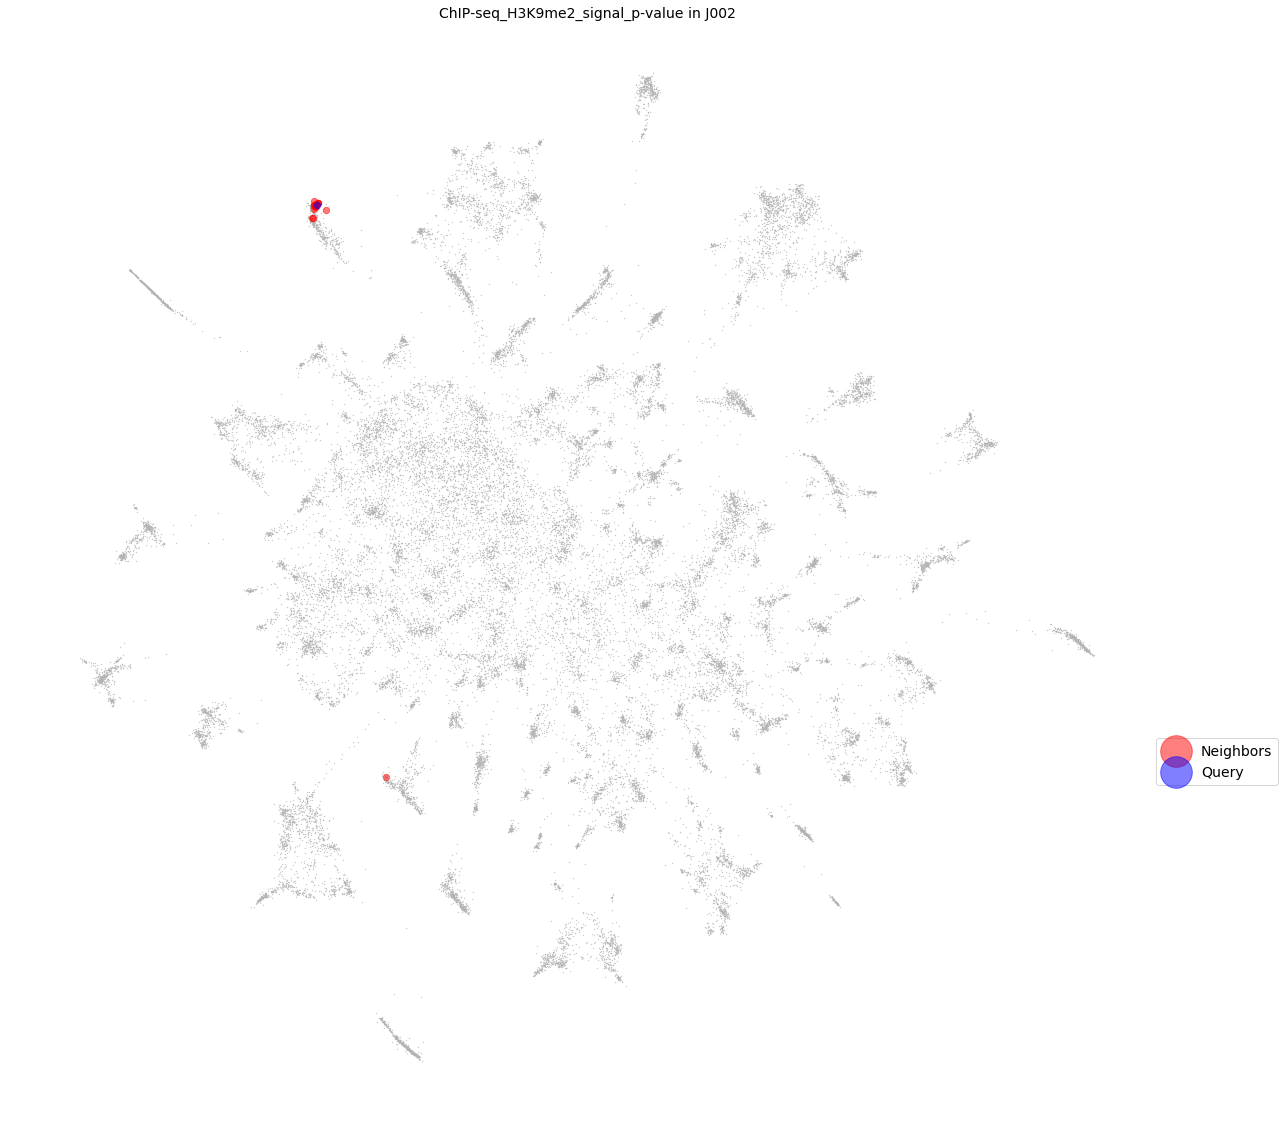

Query: ChIP-seq_YY1_signal_p-value in J004
Neighbors: [['J004' 'ChIP-seq_CHD2_signal_p-value']
 ['J004' 'ChIP-seq_ELF1_signal_p-value']
 ['J004' 'ChIP-seq_MAX_signal_p-value']
 ['J004' 'ChIP-seq_MAZ_signal_p-value']
 ['J004' 'DNase-seq_read-depth_normalized_signal']
 ['J047' 'ChIP-seq_YY1_signal_p-value']
 ['J202' 'ChIP-seq_YY1_signal_p-value']
 ['J250' 'ChIP-seq_YY1_signal_p-value']
 ['J258' 'ChIP-seq_MAX_signal_p-value']
 ['J258' 'ChIP-seq_YY1_signal_p-value']
 ['J385' 'ChIP-seq_MAX_signal_p-value']
 ['J385' 'ChIP-seq_YY1_signal_p-value']
 ['J599' 'ChIP-seq_MAX_signal_p-value']
 ['J599' 'ChIP-seq_YY1_signal_p-value']
 ['J911' 'ChIP-seq_YY1_signal_p-value']]
===========SUMMARY=============
Neighbor Assay			Neighbor Count
ChIP-seq_CHD2_signal_p-value		1
ChIP-seq_ELF1_signal_p-value		1
ChIP-seq_MAX_signal_p-value		4
ChIP-seq_MAZ_signal_p-value		1
ChIP-seq_YY1_signal_p-value		7
DNase-seq_read-depth_normalized_signal		1


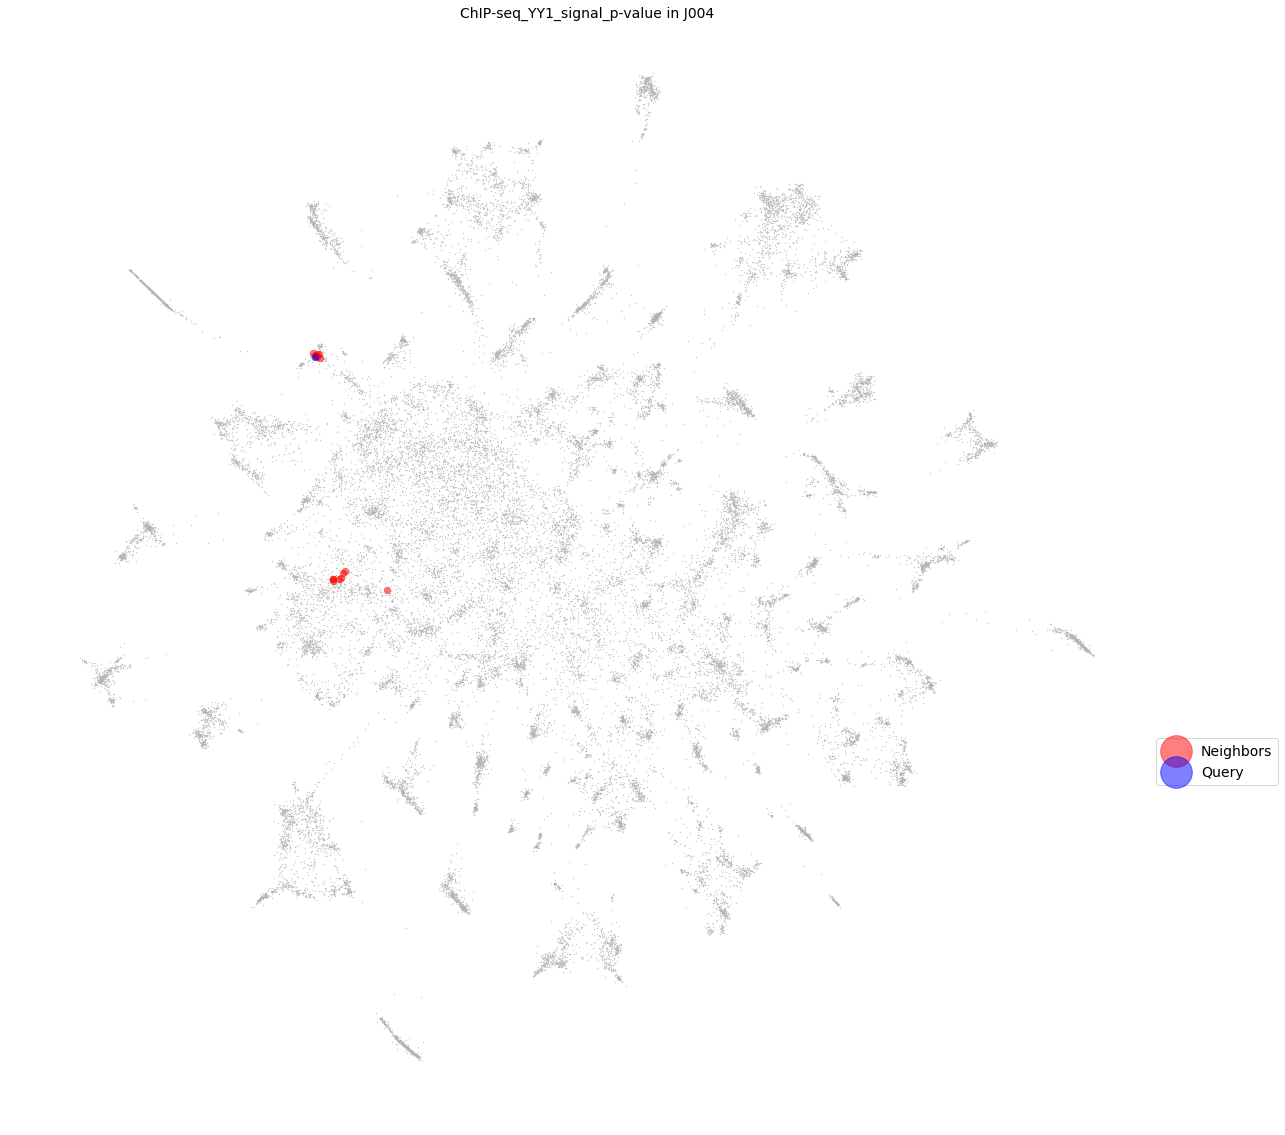

Query: ChIP-seq_SUZ12_signal_p-value in J014
Neighbors: [['J023' 'ChIP-seq_SUZ12_signal_p-value']
 ['J035' 'ChIP-seq_SUZ12_signal_p-value']
 ['J057' 'ChIP-seq_SUZ12_signal_p-value']
 ['J190' 'ChIP-seq_SUZ12_signal_p-value']
 ['J200' 'ChIP-seq_SUZ12_signal_p-value']
 ['J220' 'ChIP-seq_SUZ12_signal_p-value']
 ['J245' 'ChIP-seq_SUZ12_signal_p-value']
 ['J253' 'ChIP-seq_SUZ12_signal_p-value']
 ['J378' 'ChIP-seq_SUZ12_signal_p-value']
 ['J403' 'ChIP-seq_SUZ12_signal_p-value']
 ['J413' 'ChIP-seq_SUZ12_signal_p-value']
 ['J504' 'ChIP-seq_SUZ12_signal_p-value']
 ['J605' 'ChIP-seq_SUZ12_signal_p-value']
 ['J774' 'ChIP-seq_SUZ12_signal_p-value']
 ['J816' 'ChIP-seq_SUZ12_signal_p-value']]
===========SUMMARY=============
Neighbor Assay			Neighbor Count
ChIP-seq_SUZ12_signal_p-value		15


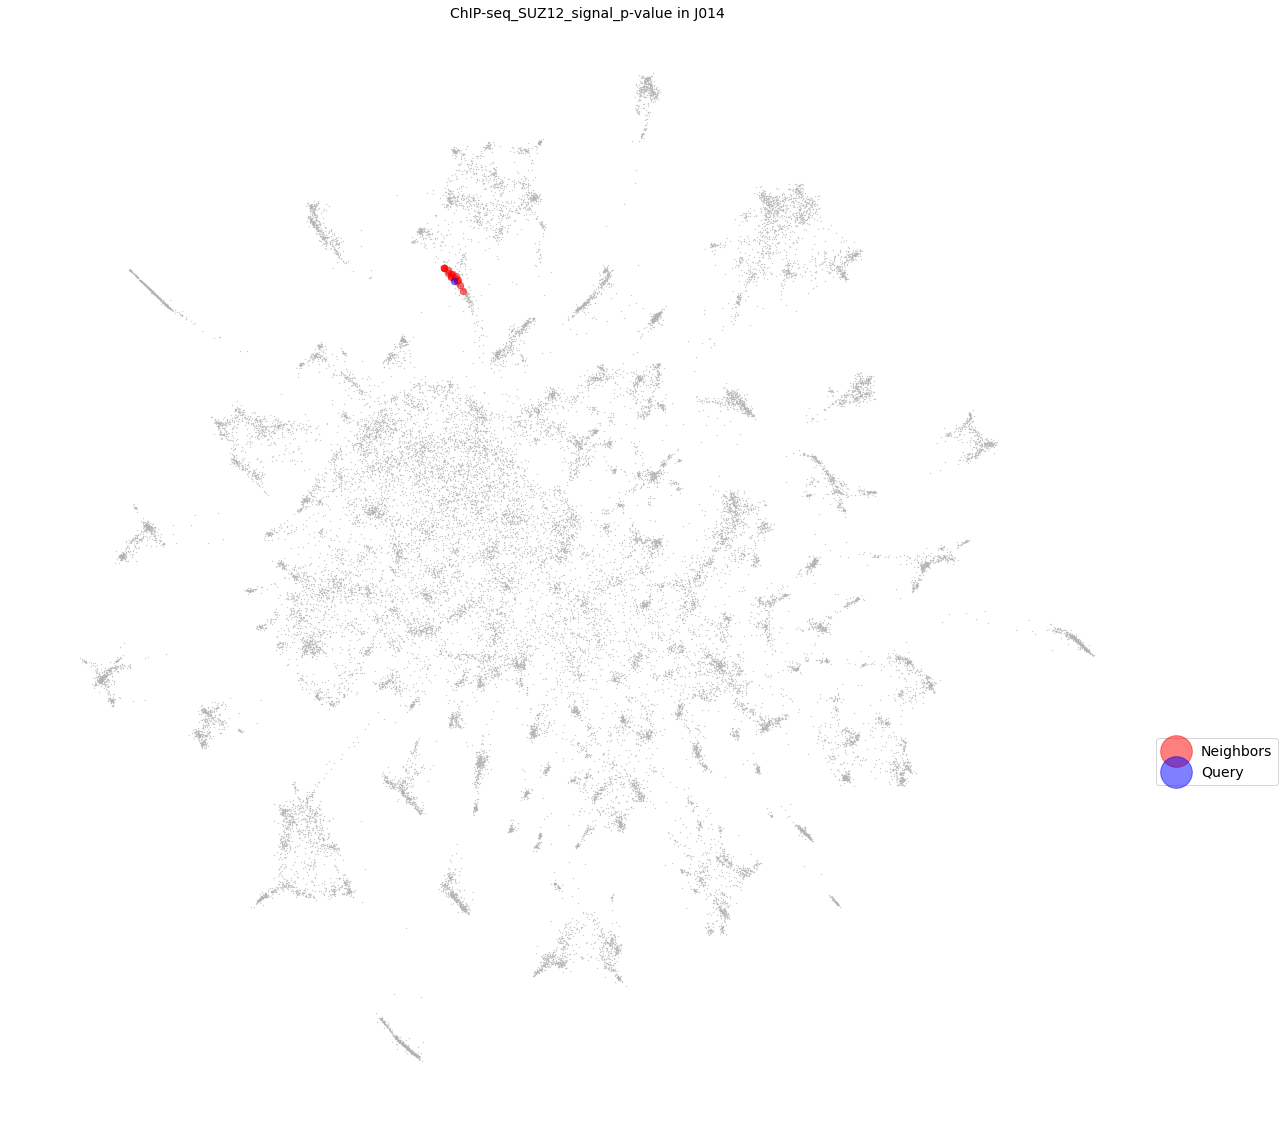

Query: ChIP-seq_MAZ_signal_p-value in J389
Neighbors: [['J011' 'ChIP-seq_CHD2_signal_p-value']
 ['J011' 'ChIP-seq_MAZ_signal_p-value']
 ['J083' 'ChIP-seq_MAZ_signal_p-value']
 ['J135' 'ChIP-seq_MAZ_signal_p-value']
 ['J171' 'ChIP-seq_MAZ_signal_p-value']
 ['J211' 'ChIP-seq_MAZ_signal_p-value']
 ['J250' 'ChIP-seq_CHD2_signal_p-value']
 ['J250' 'ChIP-seq_MAZ_signal_p-value']
 ['J300' 'ChIP-seq_MAZ_signal_p-value']
 ['J389' 'ChIP-seq_CHD2_signal_p-value']
 ['J389' 'ChIP-seq_RCOR1_signal_p-value']
 ['J389' 'ChIP-seq_SIN3A_signal_p-value']
 ['J440' 'ChIP-seq_MAZ_signal_p-value']
 ['J717' 'ChIP-seq_MAZ_signal_p-value']
 ['J816' 'ChIP-seq_MAZ_signal_p-value']]
===========SUMMARY=============
Neighbor Assay			Neighbor Count
ChIP-seq_CHD2_signal_p-value		3
ChIP-seq_MAZ_signal_p-value		10
ChIP-seq_RCOR1_signal_p-value		1
ChIP-seq_SIN3A_signal_p-value		1


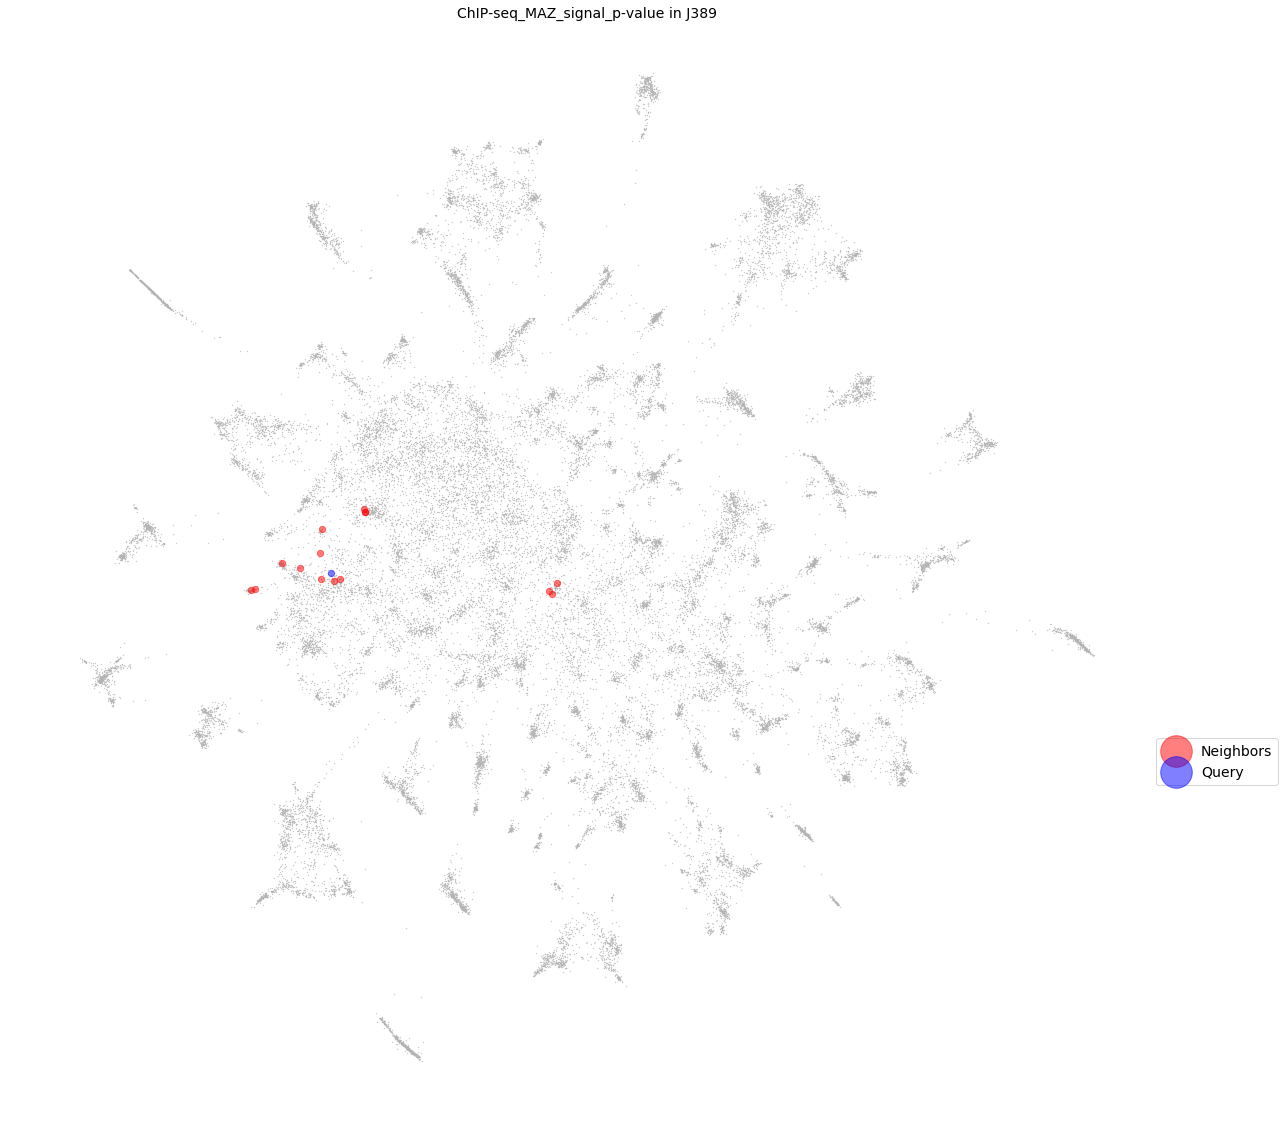

Query: polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads in J091
Neighbors: [['J105' 'polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads']
 ['J160' 'polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads']
 ['J209' 'polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads']
 ['J232' 'polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads']
 ['J291' 'polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads']
 ['J327' 'polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads']
 ['J370' 'polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads']
 ['J419' 'polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads']
 ['J457' 'polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads']
 ['J457' 'total_RNA-seq_minus_strand_signal_of_all_reads']
 ['J495' 'polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads']
 ['J495' 'total_RNA-seq_minus_strand_signal_of_all_reads']
 ['J533' 'polyA_depleted_RNA-seq_minus_strand_signal_of_all_reads']
 ['J604' 'polyA_depleted_RNA-seq_minus_strand_signal

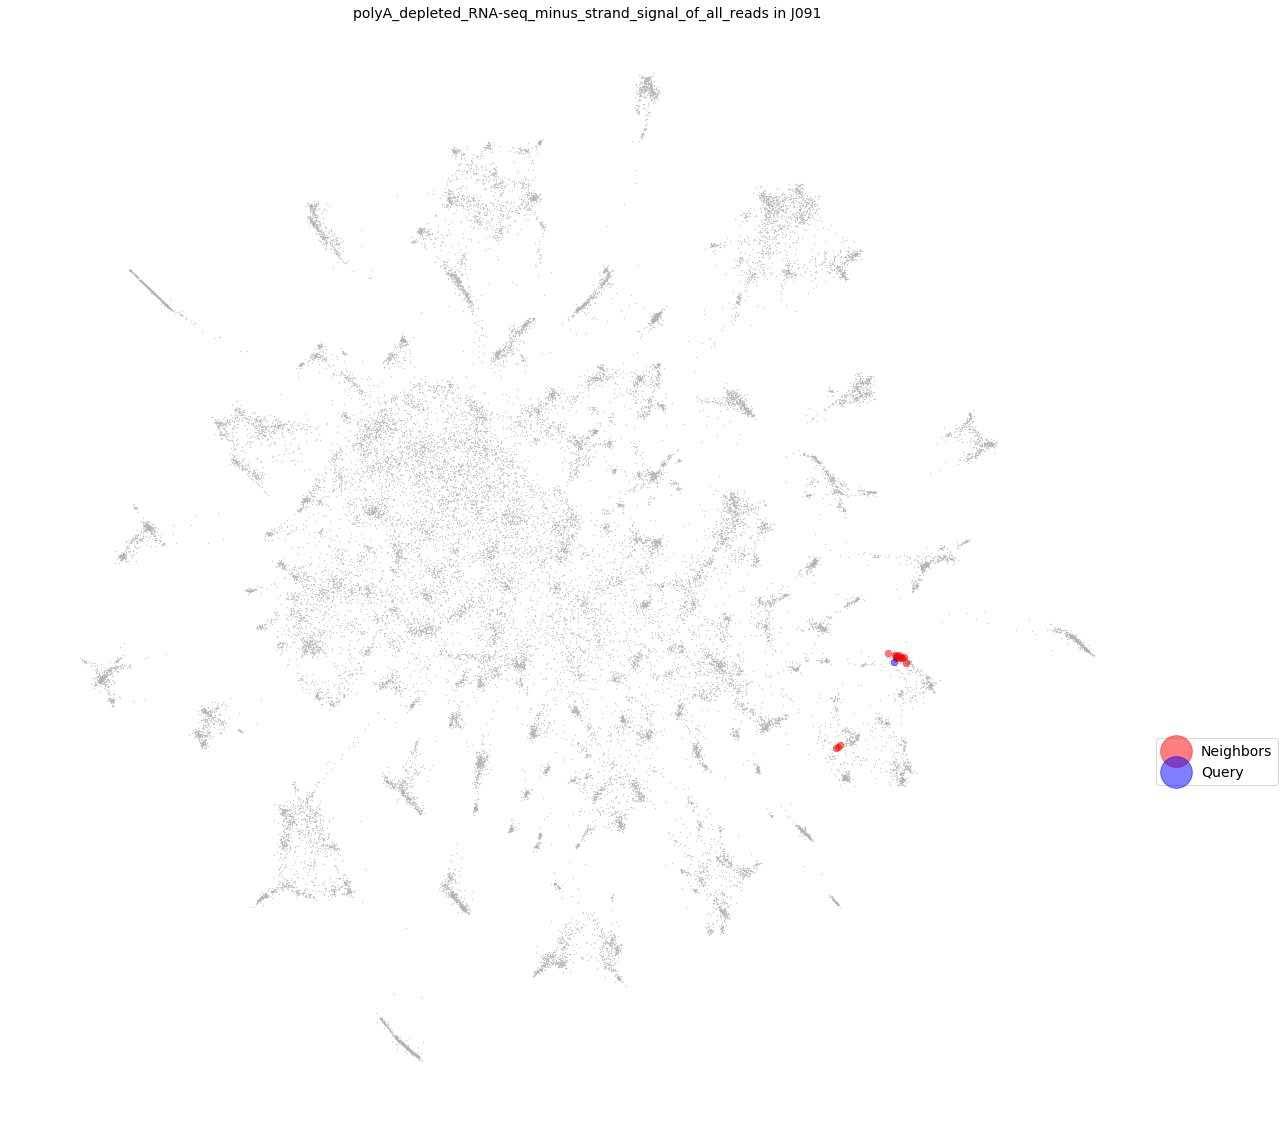

In [123]:
# Test functions above
ex_cases = [123, 236, 901, 21973, 5454] #interesting cases
#Histone: 123 vs 6999
#TF : 236 or 21973 vs 490
#RNA: 5454

for query_idx in ex_cases:
    neighbors = get_neigbors(query_idx, expt_embedding, experiments)
    #print('Neighbor Correlations: {}'.format(raw_corr[236, expt_embedding[236] != 0]))
    plot_query_neighbors(query_idx, neighbors, experiments)